In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

In [2]:
SOURCE = 'C:/Users/Cactuar/Documents/'

In [3]:
rating_table = pd.read_csv(SOURCE + 'rating_table.csv')
player_table = pd.read_csv(SOURCE + 'player_table.csv')
match_table = pd.read_csv(SOURCE + 'match_table.csv')

In [4]:
rating_table = rating_table.drop(columns='prev_id')

In [5]:
player_table = player_table.rename(columns={'id':'player_id'})

In [6]:
match_table = match_table[match_table['game']=='LotV']

In [7]:
match_table['winning_player'] = np.where(match_table['sca'] < match_table['scb'], 'scb', 'sca')

In [8]:
match_table = match_table.drop(['sca', 'scb', 'treated','event','eventobj_id','submitter_id','game','offline'], axis=1)

In [9]:
rta_id = match_table[['id','rta_id']]
rtb_id = match_table[['id','rtb_id']]

In [10]:
rta_id = rta_id.merge(rating_table, left_on='rta_id', right_on='id', how='left')
rtb_id = rtb_id.merge(rating_table, left_on='rtb_id', right_on='id', how='left')

In [11]:
rta_id = rta_id.drop(columns='id_y')
rtb_id = rtb_id.drop(columns='id_y')

In [12]:
merged_ratings = rta_id.merge(rtb_id, on='id_x', how='left')

In [13]:
merged_ratings = merged_ratings.rename(columns={'id_x':'id'})

In [14]:
lotv_merged = match_table.merge(merged_ratings, on='id', how='left')

In [15]:
lotv_merged = lotv_merged.drop(columns=['rta_id_x','rtb_id_x','rta_id_y', 'rtb_id_y', 'period_id_y', 'player_id_x', 'player_id_y','id','period_id','date','pla_id','plb_id'])

In [16]:
lotv_merged = lotv_merged.replace(['Z','T','P','R'],[1,2,3,4])

In [17]:
lotv_merged['rca'] = lotv_merged['rca'].astype(str).astype(int)
lotv_merged['rcb'] = lotv_merged['rcb'].astype(str).astype(int)

In [18]:
lotv_merged = lotv_merged.dropna()

In [19]:
# baseline majority classifier
lotv_merged['winning_player'].value_counts(normalize=True)

sca    0.626053
scb    0.373947
Name: winning_player, dtype: float64

In [20]:
train, test = train_test_split(lotv_merged, stratify=lotv_merged['winning_player'], random_state=42)
train , val = train_test_split(train, stratify=train['winning_player'], random_state=42)

In [21]:
target = 'winning_player'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns=target)
y_test = test[target]
y_train = train[target]
y_val = val[target]

In [1]:
# search.predict, brier_score~~
eval_set = [(X_train, y_train), (X_val, y_val)]
model = XGBClassifier(n_estimators=775, max_depth=10, learning_rate=0.32, min_child_weight=7, subsample=1, colsample_bytree=1, gamma=0, n_jobs=-1)
model.fit(X_train, y_train, eval_set=eval_set, eval_metric='error')
print('Validation Score:', model.score(X_val, y_val))
print('Test Score:', model.score(X_test, y_test))

NameError: name 'X_train' is not defined

In [25]:
#results = model.evals_result()
#train_error = results['validation_0']['error']
#val_error = results['validation_1']['error']
#epoch = range(len(train_error))
#plt.plot(epoch, train_error, label='Train')
#plt.plot(epoch, val_error, label='Validation')
#plt.ylim()
#plt.legend();

In [26]:
#model = XGBClassifier(n_jobs=-1, random_state=42)
#param_dist = {'max_depth': randint(3,12),
#              'learning_rate': uniform(0,1),
#              'n_estimators': randint(200, 1500),
#              'min_child_weight': randint(1,10),
#              'gamma': randint(0,5),
#              'subsample': [0.6, 0.7, 0.8, 0.9, 1],
#              'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
#              }
#
#search = RandomizedSearchCV(model,
#                            param_distributions=param_dist,
#                            n_iter=10,
#                            cv=5,
#                            scoring='accuracy',
#                            verbose=10,
#                            return_train_score=True)
#
#search.fit(X_train, y_train)

In [55]:
print('Best hyperparameters', search.best_params_)
print('Best score', search.best_score_)

Best hyperparameters {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.3228154546412785, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 775, 'subsample': 1}
Best score 0.8128388635870744


In [83]:
y_pred = search.predict(X_test)
print('test accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

test accuracy: 0.8084603258013663
              precision    recall  f1-score   support

         sca       0.83      0.87      0.85     16679
         scb       0.76      0.71      0.73      9963

   micro avg       0.81      0.81      0.81     26642
   macro avg       0.80      0.79      0.79     26642
weighted avg       0.81      0.81      0.81     26642



In [93]:
y_pred_proba = search.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred_proba)

0.8904856650962911

In [90]:
y_train.value_counts(normalize=True)

sca    0.626061
scb    0.373939
Name: winning_player, dtype: float64

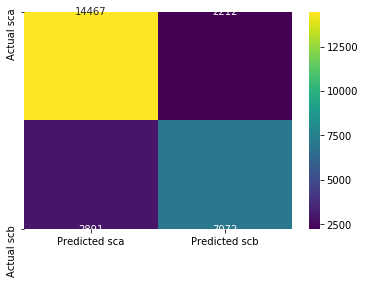

In [88]:
def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
               columns =columns, index = index)
           
  return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_test, y_pred);

In [53]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [ ]:
#plt.figure(figsize=(10,10))
#importances = pd.Series(model.feature_importances_, X_train.columns)
#importances.sort_values().plot.barh(color='grey');
permuter = PermutationImportance(model, cv='prefit',random_state=42)
permuter.fit(X_val, y_val)
feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

In [ ]:
eval_set = [(X_train, y_train), (X_val, y_val)]

In [43]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)